# Dependencias (posiblemente, ejecutar con precaución 💀)

In [ ]:
%pip install opencv-python

# Trackeo

Solo se trackea el punto B (rosa), ya que el punto A no se distingue lo suficiente en el video usado.

Erosion de la mascara eliminada por el tamaño del punto trackeado.
Dilatacion ligeramente aumentada por el mismo motivo.

Agregados graficos de posicion X e Y segun el tiempo.

Datos de posiciones y velocidades guardados en 'positions_with_speed.csv'.


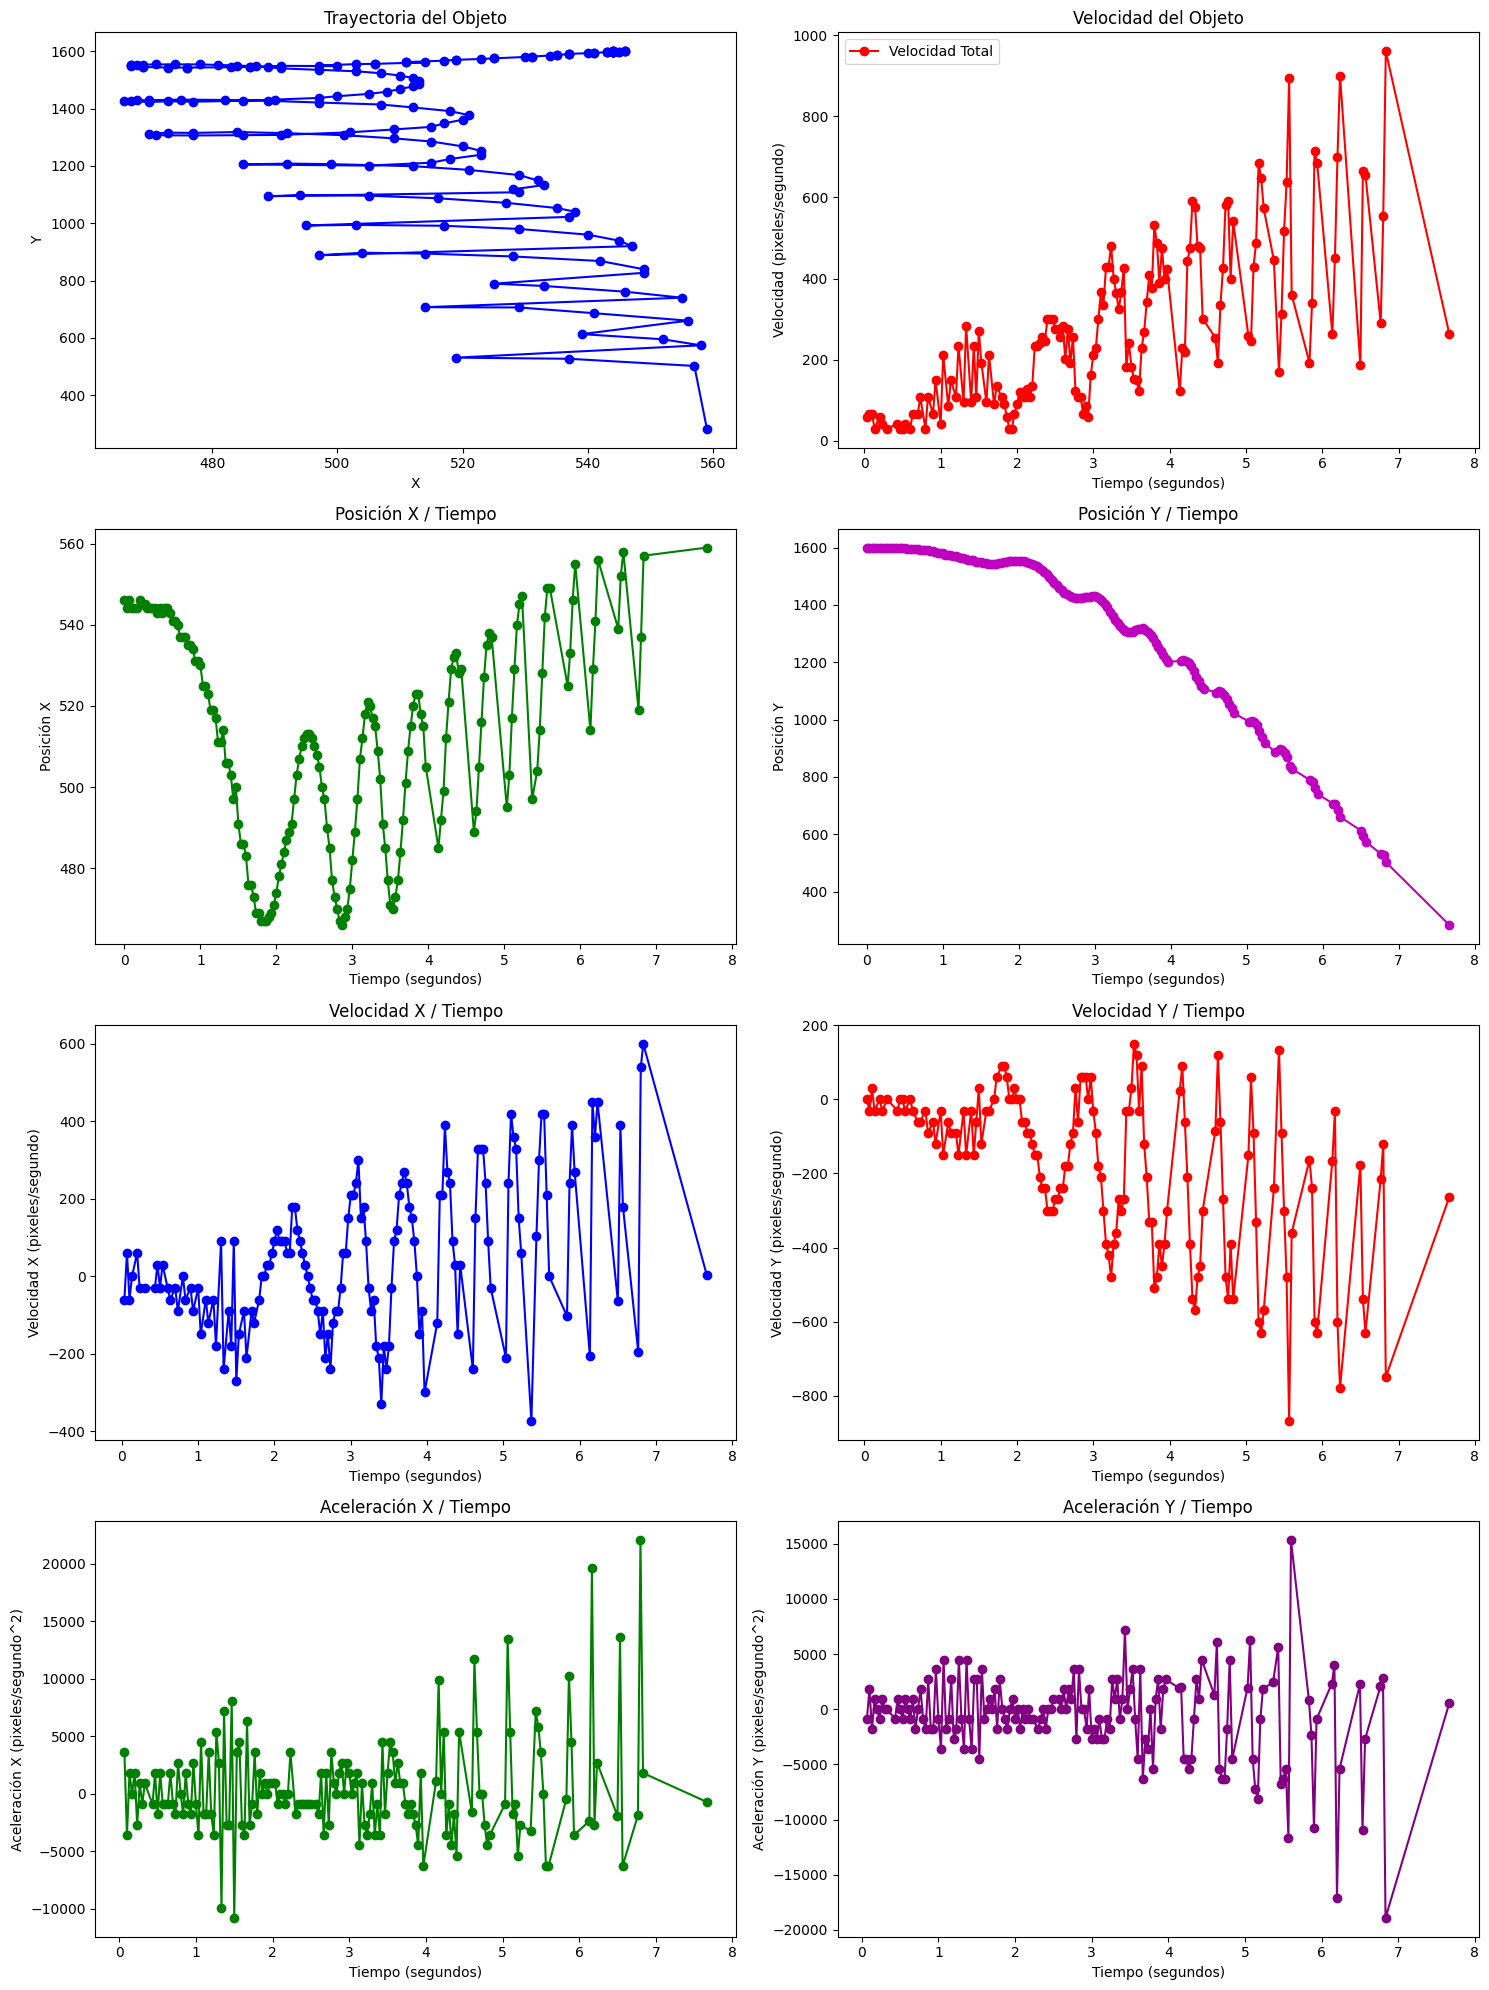

In [12]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###################################################
#      PARTE DE TRACKEO DE POR COLOR DE OPENCV    #
###################################################

# Define los límites del color en el espacio HSV
# PUNTO B
pinkLower = (140, 30, 230)
pinkUpper = (170, 122, 255)

# Carga el video
cap = cv2.VideoCapture('Videos/YoYoFreeFall1Saturated.mp4') # Local
if not cap.isOpened():
  cap = cv2.VideoCapture('content/YoYoFreeFall1Saturated.mp4') # Colab

# Variables para guardar las posiciones y tiempos
positions = []
fps = cap.get(cv2.CAP_PROP_FPS)  # Obtiene los FPS del video
frame_duration = 1.0 / fps  # Duración de cada frame en segundos
frame_count = 0

while True:
    # Captura frame por frame
    ret, frame = cap.read()

    if not ret:
        break

    # Convierte el frame al espacio de color HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Crea una máscara para el color
    mask = cv2.inRange(hsv, pinkLower, pinkUpper)

    # Realiza una serie de dilataciones y erosiones para eliminar cualquier pequeño punto en la máscara
    #mask = cv2.erode(mask, None, iterations=2) # Los puntos marcados en el YoYo son pequeños, la erosion los elimina
    mask = cv2.dilate(mask, None, iterations=3)

    # Encuentra los contornos en la máscara
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Encuentra el contorno más grande en la máscara
        c = max(contours, key=cv2.contourArea)

        # Encuentra el centro del contorno
        M = cv2.moments(c)
        if M["m00"] > 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
            center = (center_x, center_y)

            # Calcula el tiempo actual basado en el número de frames procesados
            current_time = frame_count * frame_duration
            positions.append((current_time, center_x, cap.get(cv2.CAP_PROP_FRAME_HEIGHT) - center_y))

            # Dibuja el contorno y el centro en el frame original
            cv2.drawContours(frame, [c], -1, (0, 255, 0), 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)

    # Muestra el frame con el tracking
    # imshow() necesita display, no funciona en Colab
    #cv2.imshow('Object Tracking', frame)

    # Rompe el bucle si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Incrementa el contador de frames
    frame_count += 1

# Libera la captura y cierra las ventanas
cap.release()
cv2.destroyAllWindows()

##########################################################################################
#                                CREACION DE DATAFRAME                                   #
##########################################################################################
# Crea un DataFrame con las posiciones en funcion del tiempo que capturo el codigo de opencv
df = pd.DataFrame(positions, columns=['Time (sec)', 'X', 'Y'])

# Calcula las diferencias entre posiciones y tiempos, lo agrega al dataframe
#diff: es una funcion que calcula la diferencia entre los elementos consecutivos, por ejemplo de tiempo en este caso.
#fillna(0): remplaza los elementos vacios por un 0 para que no tire error.
df['Delta_Time'] = df['Time (sec)'].diff().fillna(0)
df['Delta_X'] = df['X'].diff().fillna(0)
df['Delta_Y'] = df['Y'].diff().fillna(0)


# Calcula la velocidad en X y Y a partir de las diferencias en posicion y el cambio en el tiempo, lo agrega al dataframe
df['Speed_X'] = df['Delta_X'] / df['Delta_Time']
df['Speed_Y'] = df['Delta_Y'] / df['Delta_Time']

# Reemplaza inf y -inf por 0 en las velocidades en x e y (por si se va al infinito por dividir por cero por ejemplo)
df['Speed_X'] = df['Speed_X'].replace([np.inf, -np.inf], 0)
df['Speed_Y'] = df['Speed_Y'].replace([np.inf, -np.inf], 0)

# Calcula la velocidad total, lo agrega al dataframe
df['Speed'] = np.sqrt(df['Speed_X']**2 + df['Speed_Y']**2)

# Reemplaza inf y -inf por 0 en la velocidad total
df['Speed'] = df['Speed'].replace([np.inf, -np.inf], 0)

# Calcular la aceleración en X e Y
df['Acceleration_X'] = df['Speed_X'].diff() / df['Delta_Time']
df['Acceleration_Y'] = df['Speed_Y'].diff() / df['Delta_Time']

# Calcula la aceleración total, lo agrega al dataframe
df['Acceleration'] = np.sqrt(df['Acceleration_X']**2 + df['Acceleration_Y']**2)

# Reemplaza inf y -inf por 0 en la aceleración total
df['Acceleration'] = df['Acceleration'].replace([np.inf, -np.inf], 0)

# Separar aceleracion y velocidad para eliminar ruido
df_speed = df[['Time (sec)', 'Speed_X', 'Speed_Y', 'Speed']][df['Speed'] != 0].copy()
df_acceleration = df[['Time (sec)', 'Acceleration_X', 'Acceleration_Y', 'Acceleration']][df['Acceleration'] != 0].copy()

#############################################################################
# Guarda el DataFrame actualizado en un archivo CSV (es para chequear despues si todo esta en orden nomas)
df.to_csv('positions_with_speed.csv', index=False, float_format='%.6f')

print("Datos de posiciones y velocidades guardados en 'positions_with_speed.csv'.")

##############################################################################
#                         PLOTEO                                             #
##############################################################################
# # Grafica la trayectoria y la velocidad (modulo)
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15, 20))
# Grafica la trayectoria
ax1.plot(df['X'], df['Y'], marker='o', linestyle='-', color='b')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Trayectoria del Objeto')

# Grafica la velocidad
ax2.plot(df_speed['Time (sec)'], df_speed['Speed'], marker='o', linestyle='-', color='r', label='Velocidad Total')
ax2.set_xlabel('Tiempo (segundos)')
ax2.set_ylabel('Velocidad (pixeles/segundo)')
ax2.set_title('Velocidad del Objeto')
ax2.legend()

# Grafica la posición X en función del tiempo
ax3.plot(df['Time (sec)'], df['X'], marker='o', linestyle='-', color='g')
ax3.set_xlabel('Tiempo (segundos)')
ax3.set_ylabel('Posición X')
ax3.set_title('Posición X / Tiempo')

# Grafica la posición Y en función del tiempo
ax4.plot(df['Time (sec)'], df['Y'], marker='o', linestyle='-', color='m')
ax4.set_xlabel('Tiempo (segundos)')
ax4.set_ylabel('Posición Y')
ax4.set_title('Posición Y / Tiempo')


# Gráfica la velocidad en X e Y en función del tiempo
# fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(12, 6))

# Velocidad en X
ax5.plot(df_speed['Time (sec)'], df_speed['Speed_X'], marker='o', linestyle='-', color='blue')
ax5.set_xlabel('Tiempo (segundos)')
ax5.set_ylabel('Velocidad X (pixeles/segundo)')
ax5.set_title('Velocidad X / Tiempo')

# Velocidad en Y
ax6.plot(df_speed['Time (sec)'], df_speed['Speed_Y'], marker='o', linestyle='-', color='red')
ax6.set_xlabel('Tiempo (segundos)')
ax6.set_ylabel('Velocidad Y (pixeles/segundo)')
ax6.set_title('Velocidad Y / Tiempo')


# Graficar la aceleración en X e Y en función del tiempo
# fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(12, 6))

# Aceleración en X
ax7.plot(df_acceleration['Time (sec)'], df_acceleration['Acceleration_X'], marker='o', linestyle='-', color='green')
ax7.set_xlabel('Tiempo (segundos)')
ax7.set_ylabel('Aceleración X (pixeles/segundo^2)')
ax7.set_title('Aceleración X / Tiempo')

# Aceleración en Y
ax8.plot(df_acceleration['Time (sec)'], df_acceleration['Acceleration_Y'], marker='o', linestyle='-', color='purple')
ax8.set_xlabel('Tiempo (segundos)')
ax8.set_ylabel('Aceleración Y (pixeles/segundo^2)')
ax8.set_title('Aceleración Y / Tiempo')

# Ajustar el diseño
plt.tight_layout()

# Muestra los graficos
plt.show()
